Here we will try to simulate 3 qubit and 4 qubit interactions with only single and two qubit interactions

We only need the interactions to simulate
$\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{z}$, $\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{x}$ and $\sigma_{z}\otimes \sigma_{z}\otimes \sigma_{z}\otimes \sigma_{x}$.


Out of these the 2nd one is included in the hamiltonian of toffoli so no need to do that so only $1^{st}$ and $3^{rd}$ have to be done.

In [1]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
import skquant.opt as skqopt #optimization routines
from scipy.linalg import expm

In [6]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])
dev1 = qml.device('default.qubit', wires=4)

# Hamiltonian for Toffoli
def hamiltonian_matrix1():
    H=np.pi/4*np.kron(np.kron(Z,np.kron(Z,Z)),Y) 
    
    return expm(-1j*H)

In [7]:
U=hamiltonian_matrix1()

In [8]:
len(U)

16

In [9]:

#@qml.qnode(dev)
def ansatz(params):
    l=params
    qml.IsingZZ(l[0],wires=[0,3])
    qml.IsingZZ(l[1],wires=[1,3])
    qml.IsingZZ(l[2],wires=[2,3])
    
    qml.IsingXX(l[3],wires=[0,1])
    qml.IsingXX(l[4],wires=[1,2])
    qml.IsingXX(l[5],wires=[0,2])
    
    qml.IsingYY(l[6],wires=[0,1])
    qml.IsingYY(l[7],wires=[1,2])
    qml.IsingYY(l[8],wires=[0,2])
    
    qml.IsingZZ(l[9],wires=[0,1])
    qml.IsingZZ(l[10],wires=[1,2])
    qml.IsingZZ(l[11],wires=[0,2])
    
    #qml.IsingYY(l[12],wires=[0,3])
    #qml.IsingYY(l[13],wires=[1,3])
    #qml.IsingYY(l[14],wires=[2,3])
    
    qml.RX(np.pi/2,wires=3)
    qml.IsingZZ(l[12],wires=[0,3])
    qml.RX(np.pi/2,wires=3)
    qml.RX(np.pi/2,wires=3)
    qml.IsingZZ(l[13],wires=[1,3])
    qml.RX(np.pi/2,wires=3)
    qml.RX(np.pi/2,wires=3)
    qml.IsingZZ(l[14],wires=[2,3])
    qml.RX(np.pi/2,wires=3)
    
    qml.RY(l[15],wires=3)
    
    qml.RZ(l[16],wires=0)
    qml.RZ(l[17],wires=1)
    qml.RZ(l[18],wires=2)
    
    #qml.IsingYY(l[19],wires=[0,3])
    #qml.IsingYY(l[20],wires=[1,3])
    #qml.IsingYY(l[21],wires=[2,3])

In [10]:
trotter_steps=5

In [11]:
@qml.qnode(dev1)
def circuit(params, state, apply_inv=True):
    qml.BasisState(np.array(state), wires=[0,1,2,3])
    
    for steps in range(trotter_steps):
        ansatz(params[:19])

    return qml.state()

def var_circ(params,state):
    result=(np.exp(-1j*params[0])*circuit(params[1:],state))
    
    return result

In [12]:
def get_unitary(params):
    return np.array([var_circ(params, state) for state in state_vector]).T

In [13]:
# 2nd cost the trace distance between two unitaries is taken as cost
def cost1(params):
    U_par=get_unitary(params)
    F=np.abs(np.trace(np.dot(np.transpose(np.conj(U_par)),U)))/len(U)
    
    return 1-F

In [30]:
par_arr=[]
def parameters(param):
    if cost1(param)>0.7:
        params = np.random.random(23)
        #print(cost1(param))
        par_arr.append(params)
        parameters(params)

In [81]:
parameters(params)
print("cost->",cost1(par_arr[len(par_arr)-1]))
params=par_arr[len(par_arr)-1]


KeyboardInterrupt



In [22]:
params = np.random.random(20)
Id = np.eye(16, requires_grad=False)
state_vector=np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0],[0,1,0,1],[0,1,1,0],[0,1,1,1],[1,0,0,0],[1,0,0,1],
                       [1,0,1,0],[1,0,1,1],[1,1,0,0],[1,1,0,1],[1,1,1,0],[1,1,1,1]])
print(Id[15])
print(state_vector[15])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 1 1]


In [23]:
cost1(params)

0.8814394838124243

In [24]:
cost_arr=[]
params_arr=[]
F_nat=[]

In [25]:

def optimization2(params,st):
    dev = qml.device("default.qubit.autograd", wires=4)

    opt = qml.AdagradOptimizer(stepsize=st)
    
    
    for i in range(100+1):
        params = opt.step(cost1, params)

        if i % 10 == 0:
            print(f"Cost at step {i}:", cost1(params))
            cost_arr.append(cost1(params))
            params_arr.append(params)
            print(f"fidelity of natural dynamics with actual unitary{i}:",Fidelity(hamiltonian_matrix(params*trotter_steps/2),U))

            
    if cost1(params)>0.008:
        params=np.random.random(20)
    if Fidelity(hamiltonian_matrix(params*trotter_steps/2),U)<0.99:
        st=np.random.uniform(0.01,0.2)
        optimization2(params,st)
        
            
    return params,st
        

In [ ]:
optimization2(params,0.1) # st=learning rate==stepsize

Cost at step 0: 0.6669019460593866
fidelity of natural dynamics with actual unitary0: 0.07839447223179036
Cost at step 10: 0.3383518278964729
fidelity of natural dynamics with actual unitary10: 0.16190963362733668
Cost at step 20: 0.2452475905343816
fidelity of natural dynamics with actual unitary20: 0.2297556247116586
Cost at step 30: 0.21665878718296128
fidelity of natural dynamics with actual unitary30: 0.21506280305667846
Cost at step 40: 0.20796985731984496
fidelity of natural dynamics with actual unitary40: 0.18972607303398928
Cost at step 50: 0.2031250518635549
fidelity of natural dynamics with actual unitary50: 0.17060021519467855
Cost at step 60: 0.19733619668045832
fidelity of natural dynamics with actual unitary60: 0.15851364627304348
Cost at step 70: 0.19093120762473514
fidelity of natural dynamics with actual unitary70: 0.14755954233393406
Cost at step 80: 0.18458087429265813
fidelity of natural dynamics with actual unitary80: 0.13969009694903697
Cost at step 90: 0.1795528

In [67]:
params_arr[len(params_arr)-1]

tensor([ 4.33972994e-01,  4.15062770e-01,  4.15882155e-01,
        -1.92783527e-01,  5.23163247e-01, -1.00848786e-13,
        -1.14006463e-13,  5.23163235e-01,  1.00748383e-13,
         1.13891757e-13, -2.61799388e-01,  2.39516003e-01,
         2.84082764e-01, -3.30784326e-83, -3.30072744e-83,
         3.13519038e-70, -8.32049885e-18,  5.69449569e-01,
         5.64612586e-01,  9.64969543e-01], requires_grad=True)

In [68]:
params_arr[len(params_arr)-1]*trotter_steps/2

tensor([ 1.30191898e+00,  1.24518831e+00,  1.24764647e+00,
        -5.78350580e-01,  1.56948974e+00, -3.02546359e-13,
        -3.42019389e-13,  1.56948970e+00,  3.02245149e-13,
         3.41675270e-13, -7.85398163e-01,  7.18548009e-01,
         8.52248292e-01, -9.92352979e-83, -9.90218231e-83,
         9.40557115e-70, -2.49614966e-17,  1.70834871e+00,
         1.69383776e+00,  2.89490863e+00], requires_grad=True)

In [16]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])
dev = qml.device('default.qubit', wires=4)

# Hamiltonian for Toffoli
def hamiltonian_matrix(params):
    l=params
    H=l[0]*np.kron(np.kron(I,np.kron(I,I)),I) + l[1]*np.kron(np.kron(Z,np.kron(I,I)),Z) + l[2]*np.kron(np.kron(I,np.kron(Z,I)),Z) + \
        l[3]*np.kron(np.kron(I,np.kron(I,Z)),Z) + l[4]*np.kron(np.kron(X,np.kron(X,I)),I) +\
        l[5]*np.kron(np.kron(I,np.kron(X,X)),I) + l[6]*np.kron(np.kron(X,np.kron(I,X)),I) + l[7]*np.kron(np.kron(Y,np.kron(Y,I)),I) + \
        l[8]*np.kron(np.kron(I,np.kron(Y,Y)),I) + l[9]*np.kron(np.kron(Y,np.kron(I,Y)),I) + \
        l[10]*np.kron(np.kron(Z,np.kron(Z,I)),I) + l[11]*np.kron(np.kron(I,np.kron(Z,Z)),I) + l[12]*np.kron(np.kron(Z,np.kron(I,Z)),I) + \
       l[13]*np.kron(np.kron(Z,np.kron(I,I)),Y) + l[14]*np.kron(np.kron(I,np.kron(Z,I)),Y) + l[15]*np.kron(np.kron(I,np.kron(I,Z)),Y)+\
       l[16]*np.kron(np.kron(I,np.kron(I,I)),Y) + l[17]*np.kron(np.kron(Z,np.kron(I,I)),I) +\
       l[18]*np.kron(np.kron(I,np.kron(Z,I)),I)+ l[19]*np.kron(np.kron(I,np.kron(I,Z)),I)#+ l[20]*np.kron(np.kron(Y,np.kron(I,I)),Y) + l[21]*np.kron(np.kron(I,np.kron(Y,I)),Y) + \
        #l[22]*np.kron(np.kron(I,np.kron(I,Y)),Y)
    
    return expm(-1j*H)


In [17]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [69]:
Fidelity(hamiltonian_matrix(params_arr[len(params_arr)-1]*trotter_steps/2),U)

0.9930319879137116

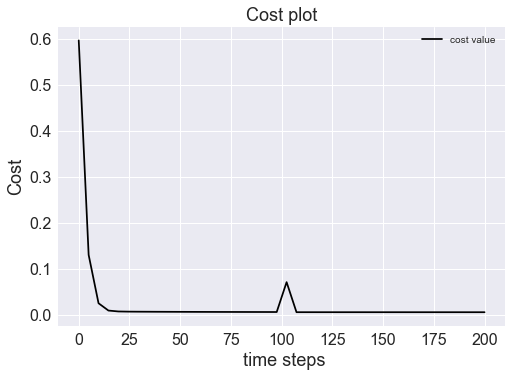

In [64]:
x=np.linspace(0,200,len(cost_arr))
y=cost_arr
plt.style.use("seaborn")
plt.plot(x,y,"black",label="cost value")
plt.title("Cost plot", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xlabel(" time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

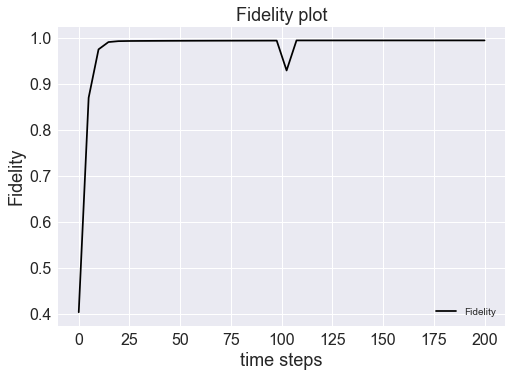

In [65]:
fidelity=[]
for elements in cost_arr:
    fidelity.append(1-elements)
    
fidelity
x=np.linspace(0,200,len(cost_arr))
y=fidelity
plt.plot(x,y,"black",label="Fidelity")
plt.title("Fidelity plot", fontsize=18)
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

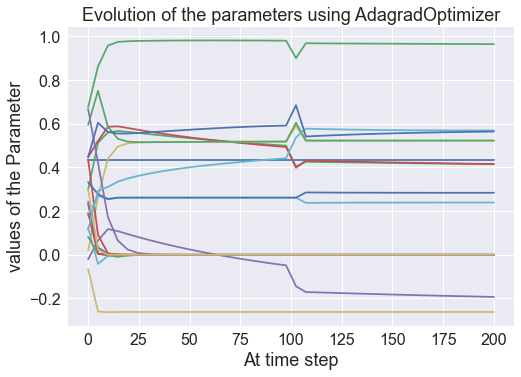

In [66]:
x=np.linspace(0,200,len(cost_arr))
y=params_arr
plt.plot(x,y)
plt.ylabel("values of the Parameter", fontsize=18)
plt.xlabel("At time step", fontsize=18)
plt.title("Evolution of the parameters using AdagradOptimizer", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

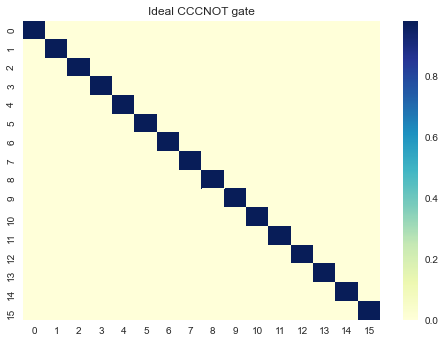

In [341]:
import seaborn
seaborn.heatmap(np.real(U),cmap="YlGnBu")
plt.title("Ideal CCCNOT gate")
plt.show()

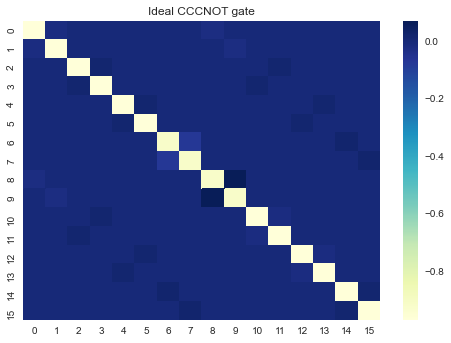

In [342]:
import seaborn
seaborn.heatmap(np.real(hamiltonian_matrix(params_arr[len(params_arr)-1]*trotter_steps/2)),cmap="YlGnBu")
plt.title("Ideal CCCNOT gate")
plt.show()

In [207]:
import orqviz

In [210]:
final_params=params_arr[len(params_arr)-1]

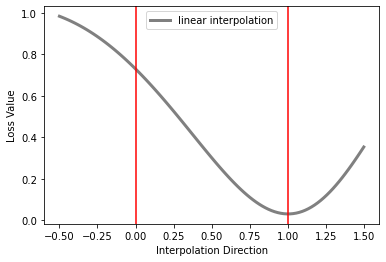

In [211]:
from orqviz.scans import perform_1D_interpolation, plot_1D_interpolation_result
end_points = (-0.5, 1.5)

interpolation_result = perform_1D_interpolation(params, final_params, 
                                                cost1, end_points=end_points)

plot_1D_interpolation_result(interpolation_result, label="linear interpolation", color="gray")

plt.legend()
plt.show()

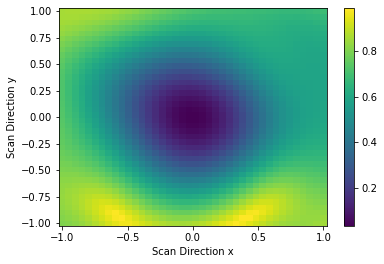

In [213]:
from orqviz.scans import perform_2D_scan, plot_2D_scan_result
from orqviz.geometric import (
    relative_periodic_wrap, 
    relative_periodic_trajectory_wrap, 
    get_random_normal_vector,
    get_random_orthonormal_vector,
)
dir1 = orqviz.geometric.get_random_normal_vector(len(params))
dir2 = orqviz.geometric.get_random_orthonormal_vector(dir1)

scan2D_result = orqviz.scans.perform_2D_scan(final_params, cost1,
                                direction_x=dir1, direction_y=dir2,
                                n_steps_x=40)
orqviz.scans.plot_2D_scan_result(scan2D_result)

In [214]:
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

In [215]:
pca = get_pca(params_arr)
scan_pca_result = perform_2D_pca_scan(pca, cost1, n_steps_x=40)

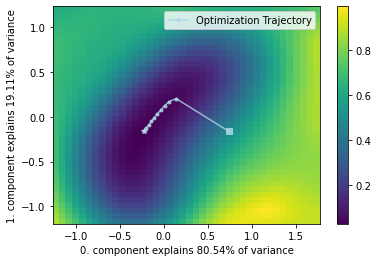

In [217]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(params_arr, pca, ax=ax, 
                                    label="Optimization Trajectory", color="lightblue")
plt.legend()
plt.show()

In [219]:
scan_pca_result2 = perform_2D_pca_scan(pca, cost1, n_steps_x=140, offset=15)

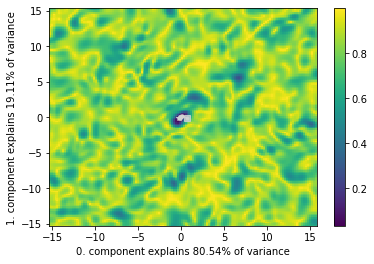

In [221]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result2, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(params_arr, pca, ax=ax)